In [1]:
import numpy as np
import cv2

from skimage.measure import compare_ssim
import argparse
import imutils

from matplotlib import pyplot as plt

In [50]:
img1 = cv2.imread("Spot_the_Difference_I.jpg")
img2 = cv2.imread("Spot_the_Difference_II.jpg")

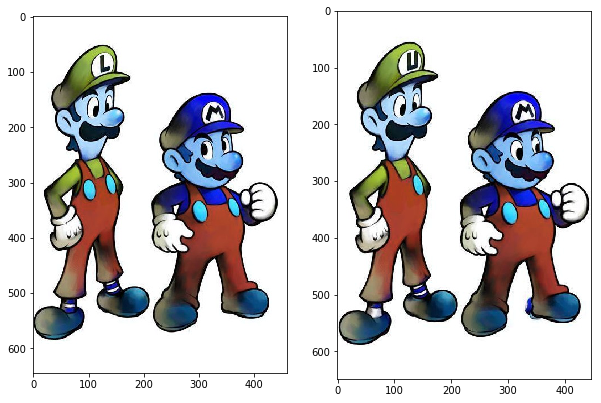

In [51]:
# show the image
fig, axs = plt.subplots(1,2, figsize=(10,10))

# show the output images
axs[0].imshow(img1)
axs[1].imshow(img2)

In [42]:
# Align both the images

def convert_image_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def get_warp_matrix(warp_mode):
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_martix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        
    return warp_matrix
        
    
def transform_image(image, size, warp_mode, warp_matrix):
    flags = cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        image_transformed = cv2.warpPerspective(image, warp_matrix, (size[1], size[0]), flags=flags)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        image_transformed = cv2.warpAffine(image, warp_matrix, (size[1], size[0]), flags=flags);

    return image_transformed


def align_images(image1, image2):
    size = image1.shape
    
    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    
    # Specify the number of iterations.
    number_of_iterations = 5000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
    warp_matrix = get_warp_matrix(warp_mode)
    
    img1_gray = convert_image_to_gray(img1)
    img2_gray = convert_image_to_gray(img2)
    
    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(img1_gray, img2_gray, warp_matrix, warp_mode, criteria)
    
    img2_aligned = transform_image(img2, size, warp_mode, warp_matrix)
    
    return img2_aligned
    


In [52]:
def denoise_image(image):
    return cv2.fastNlMeansDenoisingColored(image,None,57,10,7,21)


def image_difference(image1, image2):
    diff = cv2.absdiff(image1, image2)
    return denoise_image(diff)


def find_canny_edges(image, threshold = 200):
    src_gray = convert_image_to_gray(image)
    canny_output = cv2.Canny(src_gray, threshold, threshold * 2)
    return canny_output


def find_contours(image):
    canny_output = find_canny_edges(image)
    return cv2.findContours(canny_output, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)


(645, 459, 3) (645, 459, 3)


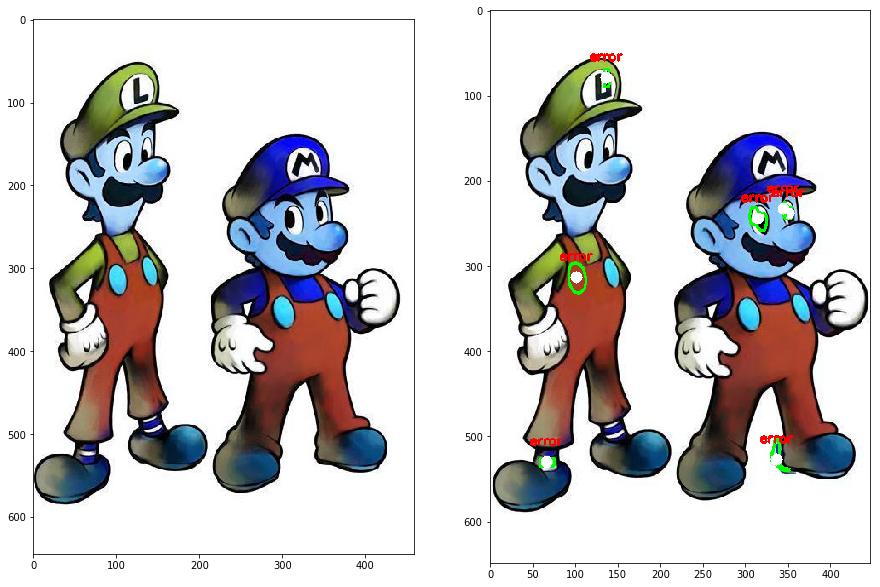

In [65]:
img2_aligned = align_images(img1, img2)
diff = image_difference(img1, img2_aligned)


cnts = find_contours(diff)
cnts = imutils.grab_contours(cnts)

for c in cnts:
    # compute the center of the contour
    M = cv2.moments(c)

    if M["m00"] > 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # draw the contour and center of the shape on the image
        cv2.drawContours(img2, [c], -1, (0, 255, 0), 2)
        cv2.circle(img2, (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(img2, "error", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


# show the image
fig, axs = plt.subplots(1,2, figsize=(15,15))

# # show the output images
axs[0].imshow(img1)
axs[1].imshow(img2)